# Neutralization assays on HA mutants

## Overview
Here we analyze neutralization assays of the serum against virus with the wildtype Perth/2009 HA and strongly selected mutants identified in the mutational antigenic profiling.

The neutralization assays where set up using the "Rachel-style 2019" format on the Bloom lab plate reader as [described here](https://jbloomlab.github.io/neutcurve/rachelstyle2019_example.html), so we can analyze the raw Excel data off the plate reader.

## Import Python packages
We use the Bloom lab [neutcurve](https://jbloomlab.github.io/neutcurve) package for fitting neutralization curves, and [plotnine](https://plotnine.readthedocs.io) for ggplot2-like plotting:

In [1]:
import os
import warnings

from IPython.display import display, HTML

import numpy

import pandas as pd

from plotnine import *

import yaml

import neutcurve
from neutcurve.colorschemes import CBPALETTE
import neutcurve.parse_excel

print(f"Using neutcurve version {neutcurve.__version__}")

Using neutcurve version 0.3.0


/fh/fast/bloom_j/software/conda_v2/envs/BloomLab/lib/python3.6/site-packages/dmslogo/logo.py:40: MatplotlibDeprecationWarning: 
The createFontList function was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use FontManager.addfont instead.
  matplotlib.font_manager.findSystemFonts(_FONT_PATH)))


Set output format of pandas Data Frames:

In [2]:
pd.set_option('display.float_format', '{:.3g}'.format)

Hide warnings that can clutter output:

In [3]:
warnings.simplefilter('ignore')

## Configuration and setup
Read general configuration from [config.yaml](config.yaml):

In [4]:
with open('config.yaml') as f:
    config = yaml.safe_load(f)

Read the neutralization assay configuration from the specified file:

In [5]:
print(f"Reading neutralization assay setup from {config['neut_config']}")

with open(config['neut_config']) as f:
    neut_config = yaml.safe_load(f)

Reading neutralization assay setup from data/neut_config.yaml


Get the output directory:

In [6]:
outdir = config['neut_curves_outdir']
os.makedirs(outdir, exist_ok=True)
print(f"Output will be written to {outdir}")

Output will be written to results/neut_curves


## Read neutralization data
Next, for each dict in *neut_config*, we use
[neutcurve.parse_excel.parseRachelStyle2019](https://jbloomlab.github.io/neutcurve/neutcurve.parse_excel.html#neutcurve.parse_excel.parseRachelStyle2019) to create a tidy
data frame appropriate for passing to
[neutcurve.CurveFits](https://jbloomlab.github.io/neutcurve/neutcurve.curvefits.html#neutcurve.curvefits.CurveFits).
We then concatenate all the
tidy data frames to get our neutralization data:

In [7]:
neutdata = []  # store all data frame, then concatenate at end

for sampledict in neut_config:
    assert len(sampledict) == 1
    sampleset, kwargs = list(sampledict.items())[0]
    print(f"Parsing data for {sampleset}...")
    neutdata.append(neutcurve.parse_excel.parseRachelStyle2019(**kwargs))

neutdata = pd.concat(neutdata)
print(f"Read data for {len(neutdata.groupby('serum'))} sera and "
      f"{len(neutdata.groupby(['serum', 'virus']))} serum / virus pairs.")

display(HTML(neutdata.head().to_html(index=False)))

Parsing data for HC070041...
Parsing data for HC150036...
Parsing data for HC070021...
Parsing data for HC120043...
Parsing data for HC140028...
Parsing data for HC080043...
Parsing data for HC070072...
Parsing data for HC150044...
Parsing data for HC060002...
Parsing data for HC150108...
Parsing data for HC070097...
Parsing data for HC080054...
Parsing data for VIDD4...
Parsing data for ferret-Pitt2...
Read data for 14 sera and 99 serum / virus pairs.


serum,virus,replicate,concentration,fraction infectivity
HC070041,wt,1,3.13e-06,1.02
HC070041,wt,1,6.26e-06,1.06
HC070041,wt,1,1.25e-05,1.07
HC070041,wt,1,2.5e-05,1.03
HC070041,wt,1,5.01e-05,0.971


Now read in the serum info which includes names and groups for the sera, and add this to `neutdata` data frame:

In [8]:
with open(config['serum_info']) as f:
    serum_info = (pd.DataFrame(yaml.safe_load(f))
                  .transpose()
                  .rename_axis('serum')
                  .reset_index()
                  )
    
neutdata = neutdata.merge(serum_info,
                          how='left',
                          on='serum',
                          validate='many_to_one')

display(HTML(neutdata.head().to_html(index=False)))

serum,virus,replicate,concentration,fraction infectivity,name,description,group
HC070041,wt,1,3.13e-06,1.02,age-2.1,"serum from OUCRU in Ho Chi Minh City, Vietnam",child
HC070041,wt,1,6.26e-06,1.06,age-2.1,"serum from OUCRU in Ho Chi Minh City, Vietnam",child
HC070041,wt,1,1.25e-05,1.07,age-2.1,"serum from OUCRU in Ho Chi Minh City, Vietnam",child
HC070041,wt,1,2.5e-05,1.03,age-2.1,"serum from OUCRU in Ho Chi Minh City, Vietnam",child
HC070041,wt,1,5.01e-05,0.971,age-2.1,"serum from OUCRU in Ho Chi Minh City, Vietnam",child


We write the neutralization data to a CSV file in our output directory:

In [9]:
neutdatafile = os.path.join(outdir, 'neutdata.csv')
neutdata.to_csv(neutdatafile, index=False)
print(f"Wrote neutralization data to {neutdatafile}")

Wrote neutralization data to results/neut_curves/neutdata.csv


## Fit and plot neutralization curves

Now we fit the neutralization curves with a [neutcurve.CurveFits](https://jbloomlab.github.io/neutcurve/neutcurve.curvefits.html#neutcurve.curvefits.CurveFits):

In [10]:
fits = neutcurve.CurveFits(neutdata,
                           serum_col='name')

Make plots that show the curves for all replicates for each serum:

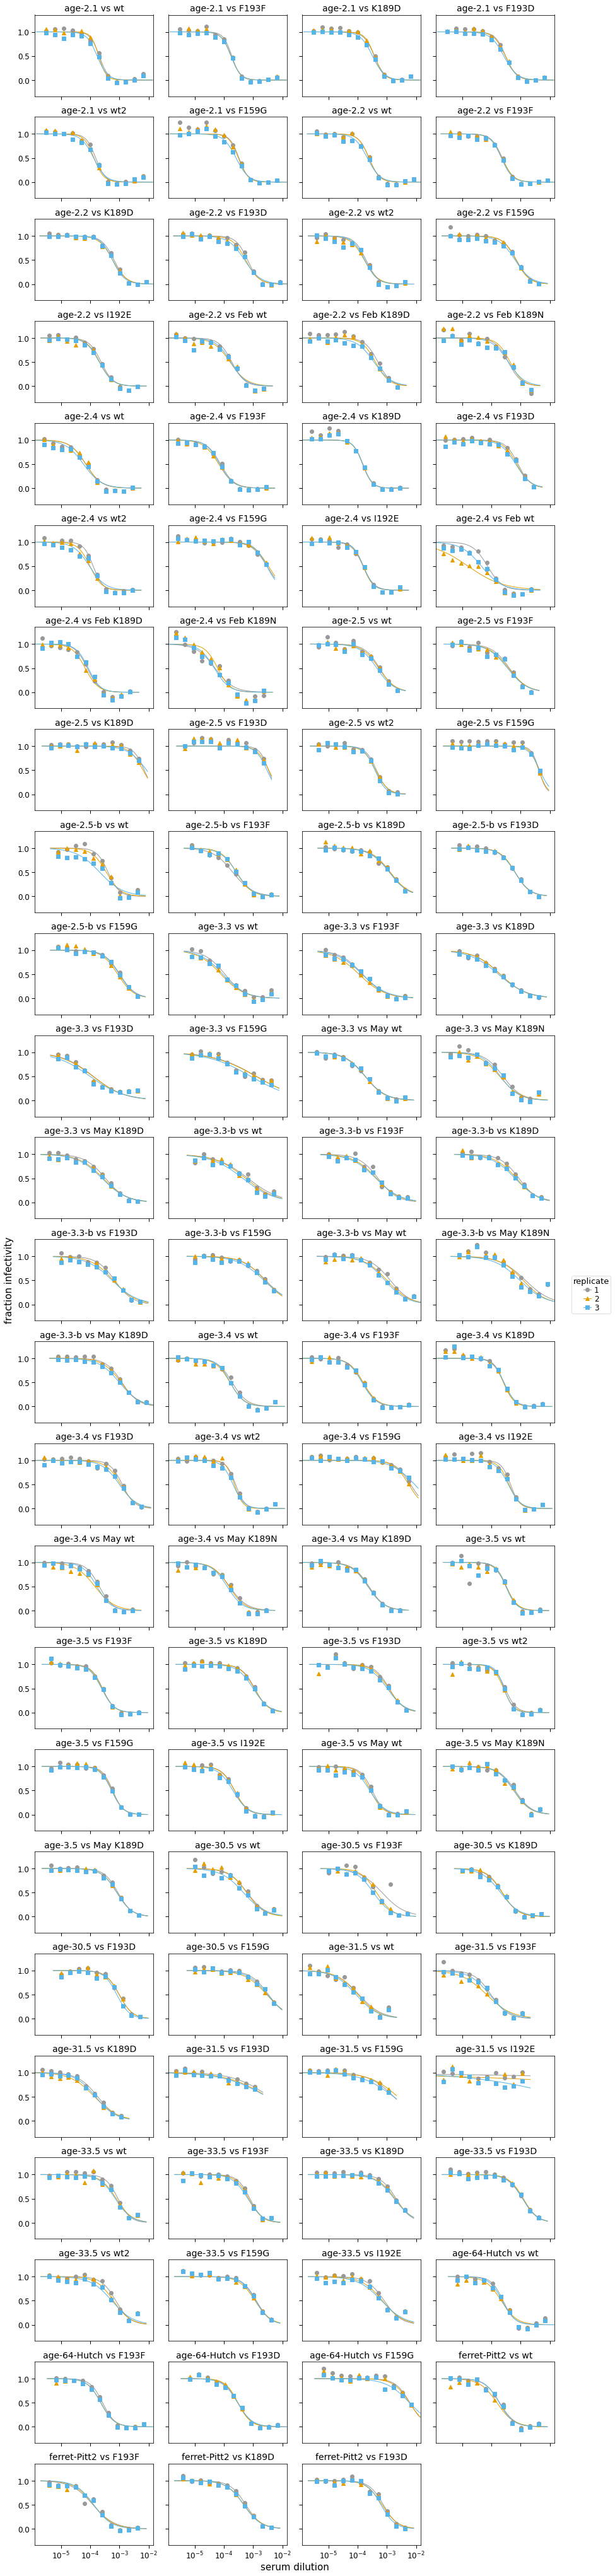

In [11]:
fig_reps, _ = fits.plotReplicates(legendtitle='replicate',
                                  xlabel='serum dilution')

Now make nice plots that show all curves for each mutant:

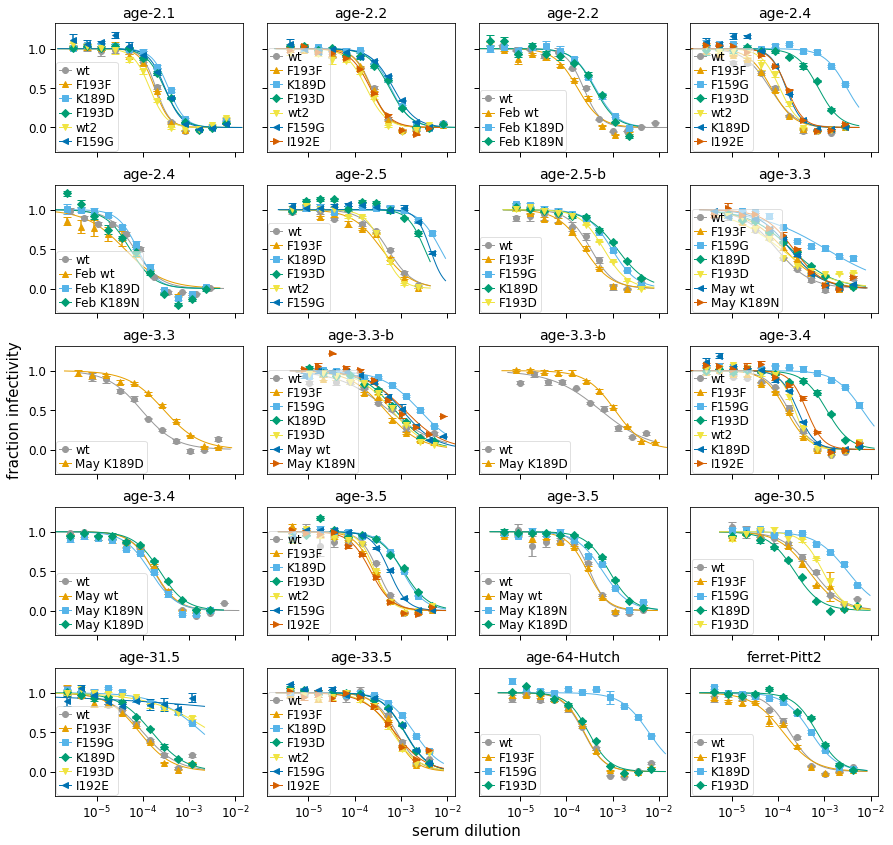

In [12]:
fig_sera_all, _ = fits.plotSera(xlabel='serum dilution',
                                   max_viruses_per_subplot=7)

For many sera, we have two wildtypes as we ran in two batches and wanted to make sure wildtype is consistent.
Clearly confirm this by just plotting the wildtype repeats for all sera:

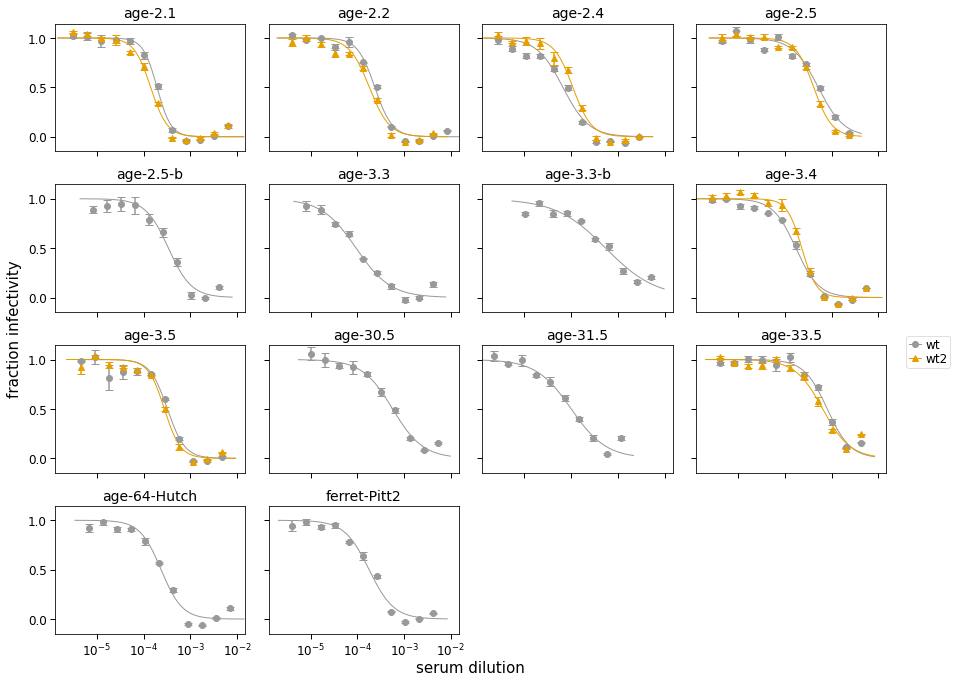

In [13]:
fig_sera_wt, _ = fits.plotSera(xlabel='serum dilution',
                               max_viruses_per_subplot=7,
                               viruses=['wt', 'wt2'])

Now make a plot just showing the original wildtype as they are clearly well correlated, and also re-ordering and adjusting the color scheme:

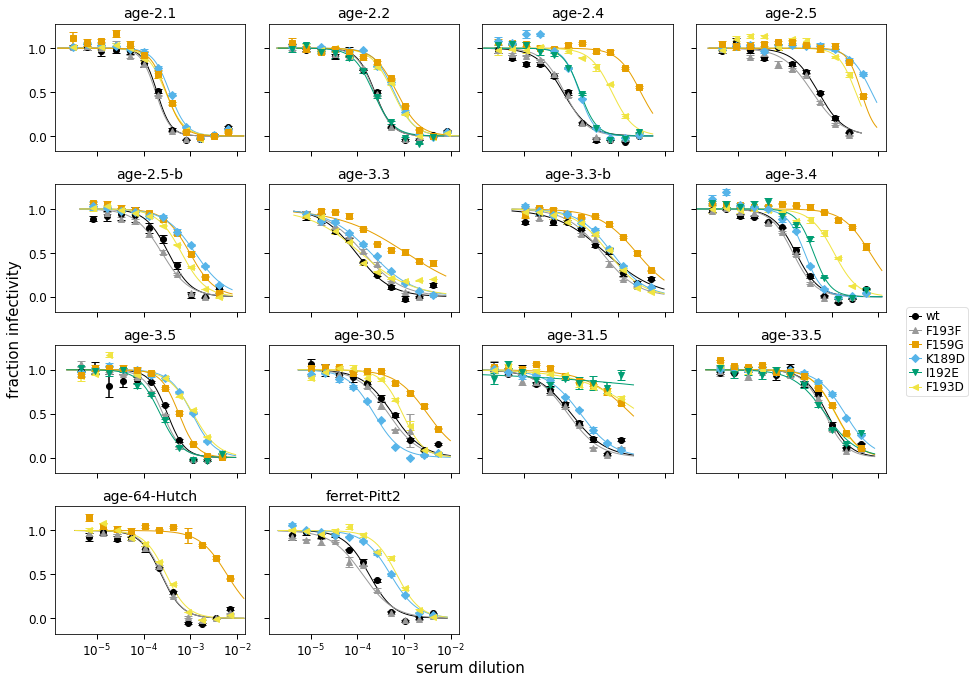

In [14]:
viruses_to_show = ['wt', 'F193F', 'F159G', 'K189D', 'I192E', 'F193D']
colors = ['black'] + list(CBPALETTE)

fig_sera, _ = fits.plotSera(xlabel='serum dilution',
                            max_viruses_per_subplot=7,
                            viruses=viruses_to_show,
                            colors=colors)

Save a PDF of the above plot:

In [15]:
plotfile = os.path.join(outdir, 'all_curves_by_sera.pdf')
print(f"Creating plot {plotfile}")
fig_sera.savefig(plotfile)

Creating plot results/neut_curves/all_curves_by_sera.pdf


Display fit parameters:

In [16]:
display(HTML(fits.fitParams().to_html()))

,serum,virus,replicate,nreplicates,ic50,ic50_bound,ic50_str,midpoint,slope,top,bottom
0,age-2.1,wt,average,3,0.000193,interpolated,0.000193,0.000193,2.9,1,0
1,age-2.1,F193F,average,3,0.00018,interpolated,0.00018,0.00018,2.76,1,0
2,age-2.1,K189D,average,3,0.000359,interpolated,0.000359,0.000359,2.41,1,0
3,age-2.1,F193D,average,3,0.000294,interpolated,0.000294,0.000294,2.2,1,0
4,age-2.1,wt2,average,3,0.000141,interpolated,0.000141,0.000141,2.44,1,0
5,age-2.1,F159G,average,3,0.000303,interpolated,0.000303,0.000303,2.47,1,0
6,age-2.2,wt,average,3,0.000237,interpolated,0.000237,0.000237,2.33,1,0
7,age-2.2,F193F,average,3,0.00023,interpolated,0.00023,0.00023,2.3,1,0
8,age-2.2,K189D,average,3,0.000609,interpolated,0.000609,0.000609,2.01,1,0
9,age-2.2,F193D,average,3,0.000574,interpolated,0.000574,0.000574,1.9,1,0
